# Drivers

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from pyinla.model import *
from pyinla.utils import *

In [3]:
# load dataset
ds = ro.r("data(Drivers); Drivers")[:192]

In [4]:
# you can mix R objects and python objects in the formula definition

params = dict(
    param_seasonal=[1, 0.1],
    season_length=12,
    intial_season=2,
)

formula = """
sqrt(y) ~ 1 + belt +
          f(trend, 
            model="rw2", 
            param=c(1.0, 0.0005),
            initial=-3) + 
          f(seasonal,
            model="seasonal", 
            season.length=season_length, 
            param=param_seasonal, 
            initial=2)
            """

In [5]:
result = inla(
    formula,
    data=pd_to_dict(ds) | params,  # as a dictionary.
    family="gaussian",
    control_inla=dict(h=0.01),
    control_predictor=dict(compute=True, link=1),
    control_compute=dict(config=True, return_marginals_predictor=True),
).improve_hyperpar()

In [6]:
result

Time used:
     = 1.47,  = 0.199,  = 0.0381,  = 1.71 
Fixed effects:
              mean    sd 0.025quant 0.5quant 0.975quant   mode kld
(Intercept) 41.413 0.169     41.082   41.412     41.745 41.412   0
belt        -5.779 1.398     -8.530   -5.777     -3.040 -5.774   0

Random effects:
  Name	  Model
    trend RW2 model
   seasonal Seasonal model

Model hyperparameters:
                                            mean      sd 0.025quant 0.5quant
Precision for the Gaussian observations 1371.084 912.932     47.822  633.438
Precision for trend                        6.344   1.281      4.581    6.128
Precision for seasonal                     0.874   0.124      0.647    0.869
                                        0.975quant    mode
Precision for the Gaussian observations    1657.13 158.632
Precision for trend                           9.56   5.491
Precision for seasonal                        1.13   0.864

Marginal log-Likelihood:  -429.30 
 is computed 
Posterior summaries for the linea

In [7]:
fitted = result.get_marginal_type("fitted.values")
modes = np.stack(fitted.apply(lambda x: x.mode()))
stds = np.stack(fitted.apply(lambda x: x.quantile([0.025, 0.975])))

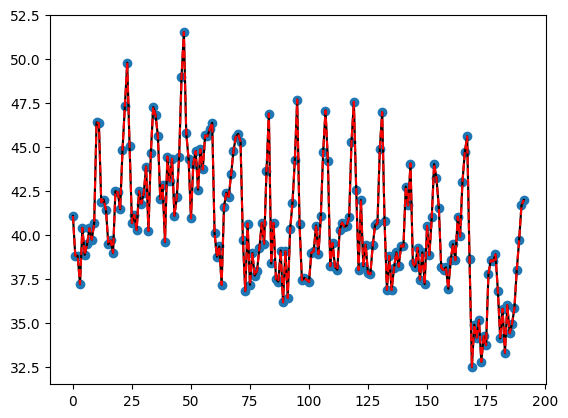

In [8]:
# posterior predictive check
xr = np.arange(len(ds))
plt.scatter(xr, np.sqrt(ds["y"].values))
plt.plot(xr, np.sqrt(ds["y"].values), c="k")
plt.plot(xr, modes, c="r", ls="--")
plt.fill_between(xr, stds[:, 0], stds[:, 1], alpha=0.2, color="r")

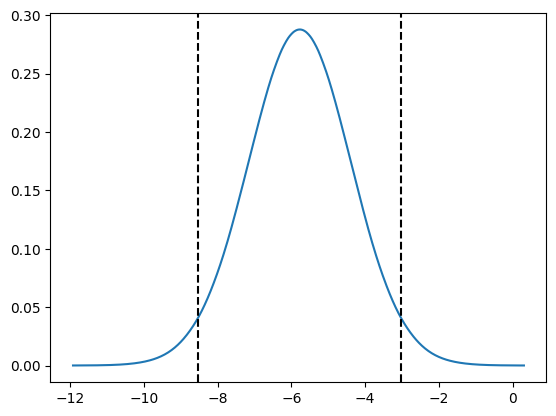

In [9]:
# check the marginal of belt. it is well below 0
belt = result.get_marginal_type("fixed").get_marginal("belt")
belt.spline().plot()
for i in belt.ci(0.95):
    plt.axvline(i, c="k", ls="--")